<a href="https://colab.research.google.com/github/bshakhruz/DAN-templates/blob/main/DNN_video_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks on Videos Using Google Colab
---


# 1. Introduction to Google Colab

Google Colab is a free cloud service based on Jupyter Notebooks that supports free GPU and TPU usage. It's ideal for machine learning, data analysis, and education. The platform eliminates the need for expensive hardware, making deep learning more accessible.



# 2. Setting up the Colab Environment

- **Enable GPU/TPU**: Go to `Edit` > `Notebook Settings` or `Runtime` > `Change runtime type` and select GPU or TPU from the dropdown to accelerate your computations.

**Checkpoint:** Remember to save your notebook now to preserve this setting.

## Verifying the Accelerator Status

After enabling the hardware accelerator, run the following cell to confirm that it is active:


In [ ]:
# Verify the hardware accelerator (GPU/TPU)
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('No GPU found')
else:
    print('Found GPU at: {}'.format(device_name))

In [2]:
## 3. Installing Dependencies
!pip install --upgrade pip setuptools wheel
!pip install tensorflow opencv-python-headless
!pip3 install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


   ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.0/410.6 MB 210.0 MB/s eta 0:00:02ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 180, in 
exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 245, in 
wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", 
line 179, in resolve
    self.factory.preparer.prepare_linked_requirements_more(reqs)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/operations/prepare.py", line 552, in 
prepare_linked_requirements_more
    self._complete_partial_requirements(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal

In [1]:
# Verify installation
import tensorflow as tf
import cv2
import torch
print(f'TensorFlow version: {tf.__version__}')
print(f'OpenCV version: {cv2.__version__}')
print(f'PyTorch version: {torch.__version__}')

TensorFlow version: 2.15.0
OpenCV version: 4.8.0
PyTorch version: 2.2.1+cu121


# 3. Accessing and Preparing Video Data

Training deep learning models on video data requires organizing and preprocessing your video files into a format that your model can process. This section guides you through accessing your video data, whether stored locally or on Google Drive, and details the preprocessing steps necessary to prepare the data for model training.

## Preparing the Environment

Before you start preprocessing your video data, you'll need to install some additional dependencies.


In [ ]:
# Installing Additional Dependencies for Preprocessing Phase
!apt update && !apt install ffmpeg
!pip install moviepy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,920 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,357 kB]
Fetched 3,510 kB in 4s (932 kB/s)
Reading package lists... Done

In [ ]:
# Mounting Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

Processed 550 frames from Mr Bean (The Angriest Nanny Ever).mp4
Processed 528 frames from Indoor Surfing _ Mr. Bean Cartoon.mp4
Processed 234 frames from Peppa pig took over Mr Bean Intro Funny edited.mp4
Processed 525 frames from Magpie Hospital _ Funny Clip _ Mr. Bean Cartoon.mp4
Processed 448 frames from Mr Bean - Bad Customer Service.mp4
Processed 231 frames from Mr. Bean Animated Series Theme Song [HD].mp4
Processed 574 frames from Car chase for bottle _ Funny Clip _ Mr. Bean Official Cartoon.mp4
Total videos processed: 7
Frames in first video: 550


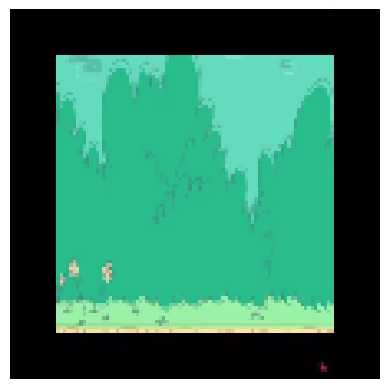

In [ ]:
# This snippet loads a video, extract frames, and preprocess them,
# NOTE: place your actual path in the 'video_path' variable

# Necessary library imports
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Placeholder for directory where videos are located
video_directory = '<your_video_directory>'

# List all video files in the directory
video_files = [file for file in os.listdir(video_directory) if file.endswith('.mp4')]

# Placeholder for labeling videos (replace with your own labels)
video_labels = {
    'video1.mp4': 0,
    'video2.mp4': 1,
    # Add as many videos as you have...
}
# Function to extract and preprocess frames
def extract_and_preprocess_frames(video_path):
    skip_frames=5
    count=0
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % skip_frames == 0:
            # Preprocess steps (e.g., resizing, normalization)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resized_frame = cv2.resize(frame_rgb, (112, 112))  # Resize frame to model input size
            frames.append(resized_frame / 255.0)  # Normalize pixel values
        count += 1

    cap.release()
    return np.array(frames)

# Process each video file
all_frames = []
for video_file in video_files:
    video_path = os.path.join(video_directory, video_file)
    processed_frames = extract_and_preprocess_frames(video_path)
    print(f"Processed {len(processed_frames)} frames from {video_file}")
    all_frames.append(processed_frames)  # Assuming you want to keep frames of all videos in one list

labels = []
for video_file, processed_frames in zip(video_files, all_frames):
    label = video_labels[video_file]
    # Extend the labels list with repeated labels for the number of frames in each video
    labels.extend([label] * len(processed_frames))

# Ensure processed_frames is correctly flattened
processed_frames = np.concatenate(all_frames, axis=0)  # This should give you a flat array of all frames


# After attempting to add all frames
print(f"Total videos processed: {len(all_frames)}")
if all_frames:
    print(f"Frames in first video: {len(all_frames[0])}")
else:
    print("No videos were processed.")
if all_frames and len(all_frames[0]) > 0:
    # Optionally, display a frame to verify preprocessing
    plt.imshow(all_frames[0][0])
    plt.axis('off')
    plt.show()
else:
    print("No frames available to display.")

# 4. Organizing the Dataset

After preprocessing the video data, the next step is to organize the dataset into distinct sets for training, validation, and testing. This ensures that we can train our model, fine-tune hyperparameters, and evaluate performance effectively.

## Splitting the Dataset

We will use `train_test_split` from `sklearn` to partition the data. The `test_size` parameter determines the proportion of the dataset to include in the test split.

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'processed_frames' contains all your preprocessed video frames
# and 'labels' is an array of corresponding labels for each video.


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    processed_frames, labels, test_size=0.2, random_state=42
)

# Further split the training set to create a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2 of the original dataset # Adjust test_size as per your requirement


# Note: Adjust the test_size parameter based on how much data you want to allocate for testing and validation.
# Now X_train, X_val, and X_test along with y_train, y_val, and y_test are ready to be used in the model training process.

# Save arrays to .npz file
np.savez('/content/dataset_splits.npz', X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

In [ ]:
# Save Data Splits
import numpy as np

# Replace '/content/dataset_splits.npz' with your preferred save path
np.savez(
    '/content/dataset_splits.npz',
    X_train=X_train, X_val=X_val, X_test=X_test,
    y_train=y_train, y_val=y_val, y_test=y_test
)

# 5. Data Augmentation (Optional)

Data augmentation is an essential technique in the machine learning workflow, particularly when dealing with image and video data. By applying random transformations to your training data, you can artificially expand the size and variance of your dataset. This process is key to preventing overfitting and helps the model generalize better to new, unseen data.

In this section, we'll use Keras's preprocessing layers to implement on-the-fly data augmentation.

## Why Data Augmentation?

- **Improves Generalization:** By simulating a broader set of variations, the model is less likely to memorize specific data points.
- **Addresses Overfitting:** Especially in scenarios with limited data, augmentation can effectively increase the dataset size.
- **Enhances Robustness:** Models trained with augmented data often perform better in real-world scenarios where data imperfections are common.

## Implementing Data Augmentation

The `ImageDataGenerator` class in Keras provides a suite of tools for on-the-fly image augmentation.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define your data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=40,        # Random rotations from 0 to 40 degrees
    width_shift_range=0.2,    # Random horizontal shifts
    height_shift_range=0.2,   # Random vertical shifts
    shear_range=0.2,          # Shear transformations
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flips
    fill_mode='nearest'       # Strategy for filling in new pixels
)

# Visualization of Data Augmentation
# Let's visualize some augmented examples to ensure our transformations are correct.
x_sample = X_train[0]
y_sample = y_train[0]

# Generate and plot a batch of augmented images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()
for ax in axes:
    # Apply a random transformation
    augmented_image = datagen.random_transform(x_sample)
    ax.imshow(augmented_image)
    ax.axis('off')
plt.tight_layout()
plt.show()

# To use data augmentation during training, pass the datagen.flow(...) as the training data in model.fit
# Example: model.fit(datagen.flow(X_train, y_train, batch_size=32), ...)

# 6. Overview of Different Architectures for Video Analysis

Selecting the right architecture for video analysis is pivotal to the success of your machine learning project. Below, we delve into several popular architectures, highlighting their uses and explaining how they work. Understanding these will help you choose the best fit for your project's needs.

## CNNs (Convolutional Neural Networks)

- **Use:** Primarily for extracting spatial features from video frames.
- **Explanation:** CNNs excel in identifying patterns, shapes, and textures within images, making them suitable for frame-level analysis.
- **Foundational Papers:** [Gradient-based learning applied to document recognition by LeCun et al.](https://ieeexplore.ieee.org/document/726791)

## RNN/LSTM/GRU

- **Use:** Best for analyzing temporal dependencies in video sequences.
- **Explanation:** RNNs and their variants, LSTM and GRU, are designed to model sequential data, capturing the temporal dynamics crucial for understanding video content over time.
- **Foundational Papers:**
  - RNN: [Finding Structure in Time by Elman.](https://crl.ucsd.edu/~elman/Papers/fsit.pdf)
  - LSTM: [Long Short-Term Memory by Hochreiter & Schmidhuber.](https://www.bioinf.jku.at/publications/older/2604.pdf)
  - GRU: [Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation by Cho et al.](https://arxiv.org/abs/1406.1078)

## 3D CNNs

- **Use:** For analyzing videos by extracting both spatial and temporal features.
- **Explanation:** By adding a time dimension to the convolutional layers, 3D CNNs can process sequences of frames, making them adept at recognizing actions and events in videos.
- **Foundational Paper:** [3D Convolutional Neural Networks for Human Action Recognition by Ji et al.](https://ieeexplore.ieee.org/document/6165309)

## Two-Stream Networks

- **Use:** For a comprehensive analysis by considering both spatial and temporal information.
- **Explanation:** This approach uses a dual-stream model, one for spatial features from single frames and another for temporal features from frame sequences, offering a balanced analysis.
- **Foundational Paper:** [Two-stream convolutional networks for action recognition in videos by Simonyan & Zisserman.](https://arxiv.org/abs/1406.2199)


## Transformers (e.g., Vision Transformers - ViT)

- **Use:** For tasks where capturing long-range dependencies within videos is crucial.
- **Explanation:** Adapting the attention mechanism from NLP, Vision Transformers process videos in a manner that emphasizes the interrelation of different parts of the video, both spatially and temporally.
- **Foundational Papers:**
  - General Transformers: [Attention is All You Need by Vaswani et al.](https://arxiv.org/abs/1706.03762)
  - Vision Transformers: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al.](https://arxiv.org/abs/2010.11929)

---


## Choosing Your Neural Architecture Template

When selecting an architecture, consider the following:

- **Nature of the Task:** Is your focus on understanding the content of individual frames (CNN), the movement between frames (RNN, 3D CNN), or a combination of both (Two-Stream, Transformers)?
- **Complexity of the Video Data:** More complex data might benefit from architectures that can capture a wide range of dependencies, like Transformers.
- **Computational Resources:** Some models, especially 3D CNNs and Transformers, are more computationally intensive than others.

### Tips for Customization:

- **Adjusting Parameters:** Tailor parameters like `frame_height`, `frame_width`, and `num_classes` according to your dataset.
- **Preprocessing Needs:** Different architectures may require specific forms of input preprocessing. Ensure your data pipeline is compatible with your chosen model.

After considering these aspects, select the architecture template that aligns with your project's goals from the list below. Each choice entails specific considerations for dataset dimensions and task specifications (e.g., classification, detection).

1. **CNN for Spatial Features:** Ideal for projects focusing on frame-level analysis.
2. **RNN/LSTM for Temporal Features:** Suited for understanding sequences and temporal patterns.
3. **3D CNN for Spatio-Temporal Features:** Best for capturing actions and events over time.
4. **Two-Stream Network:** Offers a comprehensive analysis by leveraging both spatial and temporal data.
5. **Transformers:** For advanced projects requiring attention to complex patterns in large datasets.

Remember to customize your model based on the specific needs of your dataset and the computational resources available to you.

### Basic CNN Model for Spatial Feature Extraction

This CNN model is structured to extract spatial features from individual video frames, making it suitable for image-based analysis tasks within videos. Below is the template for creating a basic CNN:

In [ ]:
# Basic CNN Model for Spatial Feature Extraction

import tensorflow as tf
from tensorflow.keras import layers, models

# Adjust these parameters to fit your dataset
frame_height = 112  # Height of the video frame
frame_width = 112   # Width of the video frame
num_classes = 7    # Number of output classes

# Basic CNN Model
model_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(frame_height, frame_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model_cnn.summary()

# Compile the model
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### RNN/LSTM for Temporal Feature Extraction

This cell demonstrates how to set up a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers. It's designed for extracting temporal features from sequences of video frames, which is crucial for understanding activities, actions, or any phenomena that evolve over time.

In [ ]:
# RNN/LSTM for Temporal Feature Extraction
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Adjust these parameters to fit your dataset
timesteps = 100  # Length of your sequences
features = 128   # Features extracted from each frame or timestep
num_classes = 10 # Number of output classes

# RNN Model with LSTM
model_rnn = Sequential([
    LSTM(64, input_shape=(timesteps, features), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

model_rnn.summary()

# Compile the model
model_rnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3D CNN for Spatio-Temporal Feature Extraction

This section introduces the setup for a 3D Convolutional Neural Network (3D CNN) designed to capture both spatial and temporal features from video clips. This model is capable of understanding motion and changes across consecutive frames, which is essential for tasks like action recognition.

# 3D CNN for Spatio-Temporal Feature Extraction

A 3D CNN extends the capabilities of traditional CNNs by analyzing sequences of frames to capture temporal dynamics alongside spatial features. Here's how to implement a 3D CNN model:

In [ ]:
# 3D CNN for Spatio-Temporal Feature Extraction

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten

# Adjust these parameters to fit your dataset
frames_per_clip = 16    # Number of frames per video clip
frame_height = 112      # Height of the video frame
frame_width = 112       # Width of the video frame
num_channels = 3        # Number of color channels (RGB)
num_classes = 10        # Number of output classes

# 3D CNN Model
model_3dcnn = models.Sequential([
    Conv3D(64, (3, 3, 3), activation='relu',
           input_shape=(frames_per_clip, frame_height, frame_width, num_channels)),
    MaxPooling3D((2, 2, 2)),
    Conv3D(128, (3, 3, 3), activation='relu'),
    MaxPooling3D((2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

model_3dcnn.summary()

# Compile the model
model_3dcnn.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### Two-Stream Networks for Video Analysis

Implementing a two-stream network involves creating and training two separate models: one focused on spatial features (using a CNN) and another on temporal features (using either a 3D CNN or an RNN). The predictions from these models are then combined to produce a final output. This combination can be achieved through simple averaging or a more complex learned fusion layer.

**Note:** This approach is conceptual, and specific implementation details will vary based on your project's needs.

### Implementation Overview:

- **For Spatial Features:** Utilize the CNN model outlined earlier.
- **For Temporal Features:** Employ either the 3D CNN model or an RNN model, depending on the nature of your data and the specific temporal dynamics you wish to capture.
- **Combining Models:** A straightforward method to combine these models is to average their predictions:

In [ ]:
# Example of combining predictions
predictions = 0.5 * cnn_model.predict(spatial_data) + 0.5 * temporal_model.predict(temporal_data)

### Vision Transformers for Video Processing

Transformers have revolutionized natural language processing and are now making significant inroads into computer vision, including video processing tasks. Vision Transformers (ViT) apply the transformer architecture to image patches, treating each patch as a token similar to how words are treated in NLP. This method allows for capturing complex spatial hierarchies and has been extended to video processing to handle temporal dynamics as well.

# Transformers for Video Processing (Vision Transformers - ViT)

Vision Transformers (ViT) represent a novel approach in leveraging transformer architectures for video processing tasks. By decomposing video frames into a sequence of patches and processing these patches as tokens, ViTs can capture intricate spatial-temporal relationships within the video content.

### Preliminary Steps:

- **Base Model for Feature Extraction:** Leveraging pre-trained models like EfficientNet as a starting point for extracting features from video frames can be beneficial. These features then serve as inputs to the transformer model.

In [ ]:
# Transformers for Video Processing (Vision Transformers - ViT)

from tensorflow.keras.applications import EfficientNetB0
from vit_keras import vit

# Example for loading a pre-trained model
base_model = EfficientNetB0(include_top=False, weights='imagenet')

# 7. Training and Monitoring the Model

Training your machine learning model is a crucial step where the model learns to recognize patterns from the data. To track the model's progress and ensure that we save the best version, we'll employ callbacks like `ModelCheckpoint` and `TensorBoard`.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np

# Loading the dataset splits
data = np.load('/content/dataset_splits.npz') # Adjust according to your dataset path
X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']

# Setup callbacks
checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
tensorboard_cb = TensorBoard(log_dir='./logs')

# Train the model
history = model_cnn.fit(
    X_train, y_train,
    epochs=12,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, tensorboard_cb]
)

In [ ]:
# Enabling TensorBoard within the notebook environment
%load_ext tensorboard
%tensorboard --logdir ./logs

# 8. Hyperparameter Tuning

Hyperparameter tuning is a pivotal phase in the machine learning pipeline. This process involves optimizing the model's architecture and the training procedure to maximize its performance. Hyperparameters, unlike the model's internal parameters learned during training, need to be set beforehand and have a substantial impact on the model's learning efficiency and output quality.

Commonly tuned hyperparameters include:
- **Learning Rate**: Controls how much to adjust the model in response to the estimated error each time the model weights are updated.
- **Batch Size**: Number of training examples utilized in one iteration.
- **Number of Epochs**: Total number of times the training dataset is passed forward and backward through the neural network.
- **Architecture-Specific Parameters**: Such as the number of layers or units in a layer, which can vary significantly across different models.

### Approaches to Hyperparameter Tuning:

1. **Manual Tuning**: Relying on experience and intuition to adjust hyperparameters.
2. **Grid Search**: Exhaustively searching through a predefined list of hyperparameter values.
3. **Random Search**: Randomly selecting hyperparameter values from a defined range and evaluating their performance.
4. **Bayesian Optimization**: Using probabilistic models to guide the search for the optimum hyperparameters.
5. **Automated Tools**: Leveraging tools like Keras Tuner or Hyperopt to automate the tuning process.

### Implementing Hyperparameter Tuning:

For practical hyperparameter tuning, consider starting with either Grid Search or Random Search as they are straightforward to implement and can yield significant improvements:

---

### Manual Tuning Approach

1. **Start with a baseline model**: Set up your model with a default set of hyperparameters.
2. **Identify key hyperparameters**: Focus on those most likely to impact performance, such as learning rate or the number of layers.
3. **Iteratively adjust values**: Manually change one hyperparameter at a time and monitor the effect on model performance.
4. **Use a systematic approach**: Keep a log of changes and results to guide future adjustments.
5. **Refinement**: Once the model shows improvement, refine your search around the best-performing values.

### Grid Search Template

Grid Search exhaustively tests a predefined range of hyperparameter values, ensuring that you explore all possible combinations within your specified grid. This method is particularly useful when the number of hyperparameters and their potential values are relatively low.

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Assume 'build_model' is a function that constructs a Keras model
def build_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(12, input_shape=(input_dim,), activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=build_model)

param_grid = {
    'epochs': [10, 20],
    'batch_size': [16, 32],
    'optimizer': ['adam', 'rmsprop']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Access the best set of parameters
best_params = grid_result.best_params_

### Random Search Template

Random Search optimizes hyperparameters by sampling values from a defined distribution. This method can be more efficient than Grid Search, particularly when the hyperparameter space is large.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def build_model(optimizer='adam'):
    # Model construction (omitted for brevity)
    return model

model = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32)

param_dist = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'optimizer': ['adam', 'rmsprop']
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, n_jobs=-1, cv=3)
random_search_result = random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search_result.best_params_

### Bayesian Optimization Template

Bayesian Optimization leverages a probabilistic model to select hyperparameters that are likely to yield better results. This method is efficient for finding optimal hyperparameters with fewer trials, making it ideal for complex models.

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def objective(space):
    model = Sequential()
    model.add(Dense(units=int(space['units']), input_dim=input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=space['learning_rate']),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=20, batch_size=int(space['batch_size']), verbose=0)

    val_loss = np.min(history.history['val_loss'])
    return {'loss': val_loss, 'status': STATUS_OK}

space = {
    'units': hp.quniform('units', 50, 150, 1),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

best_params = space_eval(space, best)

### Hyperparameter Tuning with Keras Tuner

Keras Tuner simplifies the task of finding the best hyperparameters for your model. The example below outlines how to use Keras Tuner to optimize a Convolutional Neural Network (CNN) architecture.

In [ ]:
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

input_shape = (112, 112, 3)  # Example input shape; adjust as necessary
num_classes = 10  # Adjust based on your dataset

# Function to build the model (required for Keras Tuner)
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_kernel_size', values=[3, 5]),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

# Perform the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
The optimal number of units in the first dense layer is {best_hps.get('dense_units')} and the
optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Rebuild the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# 9. Evaluating the Model

After training, it's crucial to evaluate your model on the test set to understand its performance on unseen data. This step gives you insights into how well your model has learned and generalized from the training data.


In [ ]:
# Evaluate the model on the test set
y_test = np.array(y_test)

test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

## Implementing Regularization Techniques

Regularization techniques are critical in preventing overfitting, especially when you have a high-capacity model or limited data. Overfitting occurs when a model learns the noise in the training data to the extent that it negatively impacts the performance of the model on new data. Regularization methods provide ways to penalize model complexity or introduce noise to the training process to promote the generalizability of the model.

There are several regularization techniques:
- **L1 and L2 Regularization**: Penalizes the weights of the model during training, which can help to prevent overfitting by encouraging simpler models that may generalize better.
- **Dropout**: Randomly sets a fraction of input units to 0 at each update during training time, which helps to prevent overfitting by making the neural network less sensitive to the specific weights of neurons.
- **Batch Normalization**: Although primarily used to normalize the input layer by adjusting and scaling the activations, it can also have a regularizing effect.
- **Early Stopping**: Monitors the model's performance on a validation set and stops training when performance begins to degrade.

In the following code cells, we will add L2 regularization and dropout to our neural network to help with overfitting. We'll also implement early stopping to halt the training process at the optimal moment.




In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Modify your model definition to include L2 regularization and dropout
def build_regularized_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(frame_height, frame_width, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 Regularization
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer
        layers.Dense(num_classes, activation='softmax'),
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate the regularized model
model_regularized = build_regularized_model()

# Include an EarlyStopping callback
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history_regularized = model_regularized.fit(
    X_train, y_train,
    epochs=100,  # Set a high epoch limit; training may stop early
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb]  # Add early stopping to your list of callbacks
)

# Evaluate the regularized model on the test set
test_loss_reg, test_acc_reg = model_regularized.evaluate(X_test, y_test)
print(f"Test accuracy with regularization: {test_acc_reg:.2f}")

## Preparing for Fine-Tuning (if needed)

To fine-tune your model, identify which layers need adjustment and set a lower learning rate for fine-tuning. This approach delicately refines the model's ability to adapt to your specific dataset.

In [ ]:
# Example for a model with a pre-trained base
for layer in model.layers[:layer_to_freeze]:
    layer.trainable = False  # Freeze layers not intended for fine-tuning
for layer in model.layers[layer_to_freeze:]:
    layer.trainable = True  # Unfreeze layers for fine-tuning

# Adjust the learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model post adjustments to verify changes
model.summary()

In [ ]:
# Fine-Tuning the Model With the model adjusted for fine-tuning,
# continue training to refine its performance on the dataset. Monitor the training process closely to ensure improvements.

# Continue training the model
history_fine = model.fit(
    X_train, y_train,
    epochs=10,  # Adjust epochs based on when performance plateaus
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, tensorboard_cb]  # Reuse callbacks from initial training
)

## Evaluating the Model Post Fine-Tuning

After fine-tuning, evaluate the model again on the test set to assess any improvements. This step helps understand the effectiveness of your fine-tuning efforts.


In [ ]:
# Evaluate the model again
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print(f"Post Fine-Tuning Test Accuracy: {test_acc:.2f}")

## Saving the Trained Model

After training and fine-tuning, save your model to reuse it later without needing to retrain. This step is crucial for deployment.

In [ ]:
import os

# Save the entire model to an H5 file
model_cnn.save('my_model.h5')

# Check if the model file exists in the current directory
if os.path.exists('my_model.h5'):
    print('Model saved successfully as my_model.h5')
else:
    print('Model saving failed.')

## Model Loading and Inference